# Introductory work on CNN development

Sources:
* https://keras.io/getting_started/intro_to_keras_for_engineers/


In [16]:
import numpy as np
import tensorflow as tf
# from tensorflow import keras
from matplotlib import pyplot as plt

dataset_path = "00 - Datasets split by class - Watermark Removed"

# Load dataset

Found 1538 files belonging to 5 classes.
Using 1231 files for training.
Using 307 files for validation.
['01 - Acne', '02 - Wrinkles', '03 - Dry skin', '04 - Normal skin', '05 - Oily skin']


<Figure size 1800x900 with 0 Axes>

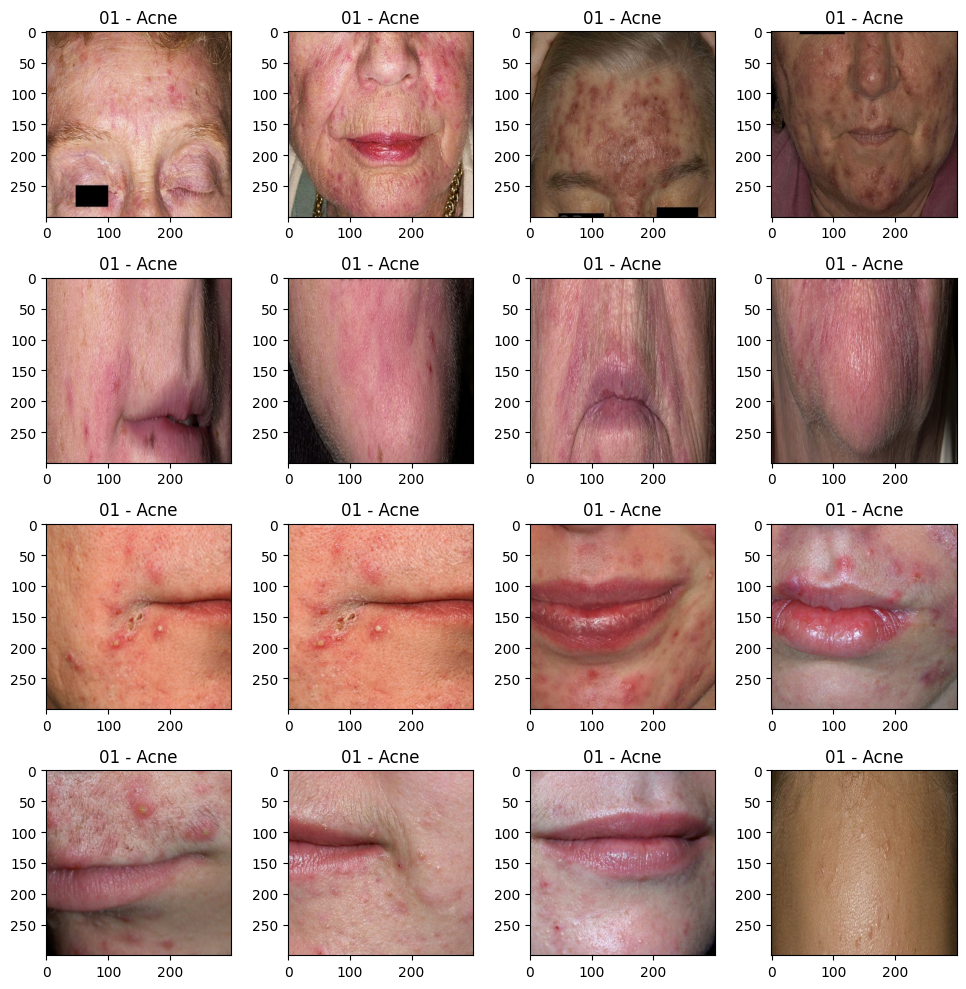

In [17]:
# Load dataset as TensorFlow Dataset Object
# Shuffle argument shuffles all images in all classes and places them into batches
# If shuffle is false, then the data is placed into batches based the order in which they are loaded 
# Image size downsizes the image to the specified resolution, it doesn't crop
# If crop_to_aspect_ratio is selected then the image is cropped
train_ds, val_ds  = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    batch_size=32,
    image_size=(300,300),
    crop_to_aspect_ratio=False,
    color_mode='rgb',
    shuffle=False,
    seed=100)

class_names = train_ds.class_names
print(class_names)

# For demonstration, iterate over the batches yielded by the dataset.
# for data, labels in train_ds:
#    print(data.shape)  # (64, 200, 200, 3)
#    print(data.dtype)  # float32
#    print(labels.shape)  # (64,)
#    print(labels.dtype)  # int32


plt.figure(figsize=(18, 9))
 
num_rows = 4
num_cols = 4
            
plt.figure(figsize=(10, 10))
# .take() selects the batch number to show
for images, labels in train_ds.take(1):
    for i in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.tight_layout()
        # plt.axis("off")

# Create artificial images to increase dataset size

Apply image transformations (flip, rotate)

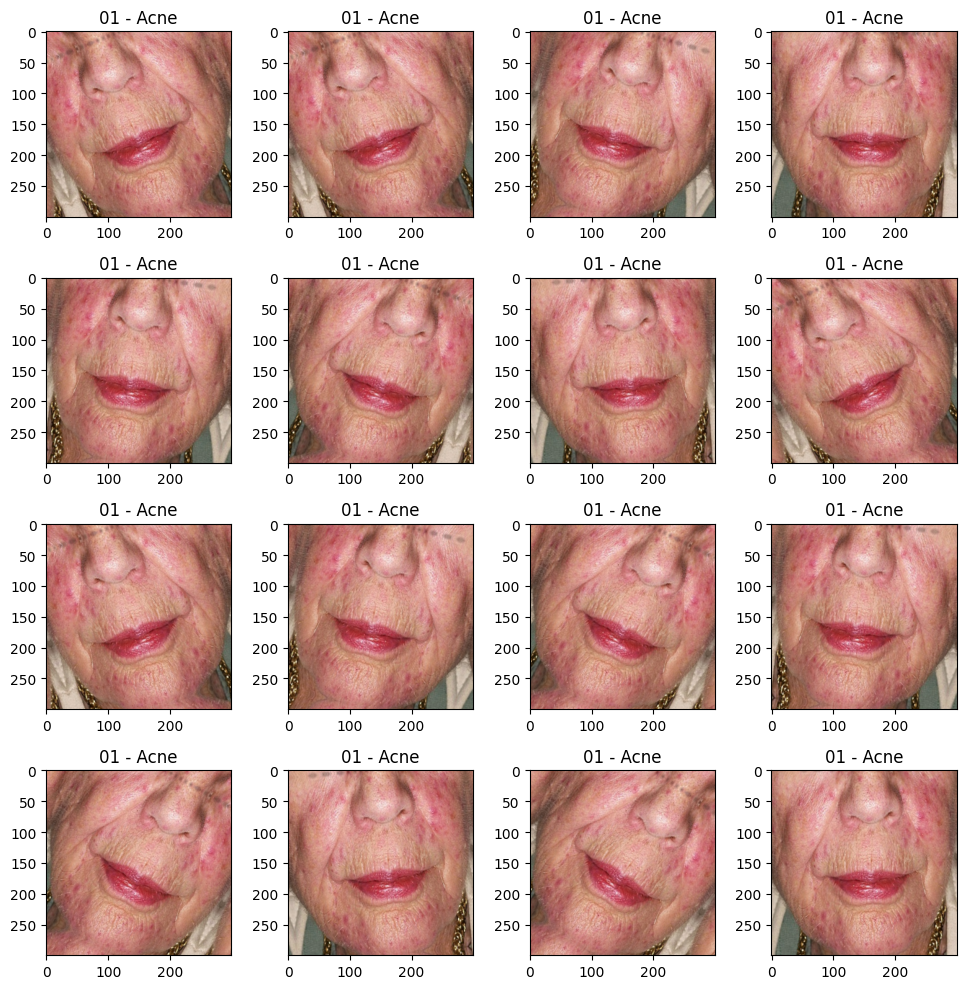

In [21]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(num_rows*num_cols):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(augmented_images[1].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.tight_layout()

# Image Preprocessing

Keras comes with preprocessing layers to aid with resizing, cropping, normalization etc.

Good to use those so that model accepts raw data (RGB [0,255]) and performs all the preprocessing directly without external API dependencies.

Pre-processing can take place before training or during training.

In [16]:
# When input data size is variable
inputs = keras.Input(shape=(None, None, 3))

# Cropping Layer
cropper = tf.keras.layers.CenterCrop(height=200, width=200)
# Scaling Layer (scales data into 0.0 - 1.0 range)
scaler = tf.keras.layers.Rescaling(scale=1.0 / 255)
preprocessed_data = scaler(cropper(inputs))


# print("shape:", output_data.shape)
# print("min:", np.min(output_data))
# print("max:", np.max(output_data))

# MNIST model example

In [18]:
# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Build a simple model
inputs = tf.keras.Input(shape=(28, 28))
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

11490434/11490434 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 rescaling_4 (Rescaling)     (None, 28, 28)            0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                              

# Callbacks to have checkpoints of model during training

In [ ]:
# Adding callbacks to store the model while it is being trained.
# Models is saved at the start and end of each batch and epoch

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='path/to/my/model_{epoch}',
        save_freq='epoch')
]
model.fit(dataset, epochs=2, callbacks=callbacks)

# Evaluate the model on validation data when training is done

In [ ]:
loss, acc = model.evaluate(val_dataset)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)

# Finding the best model configuration with hyperparameter tuning

In [19]:
# Put model in a function
# Use hp argument (hyperparameter) in any parameter to tell Keras to tune it
def build_model(hp):
    inputs = tf.keras.Input(shape=(784,))
    x = tf.keras.layers.Dense(
        units=hp.Int('units', min_value=32, max_value=512, step=32),
        activation='relu')(inputs)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [20]:
import keras_tuner

tuner = keras_tuner.tuners.Hyperband(
  build_model,
  objective='val_loss',
  max_epochs=100,
  max_trials=200,
  executions_per_trial=2,
  directory='my_dir')

ModuleNotFoundError: No module named 'keras_tuner'